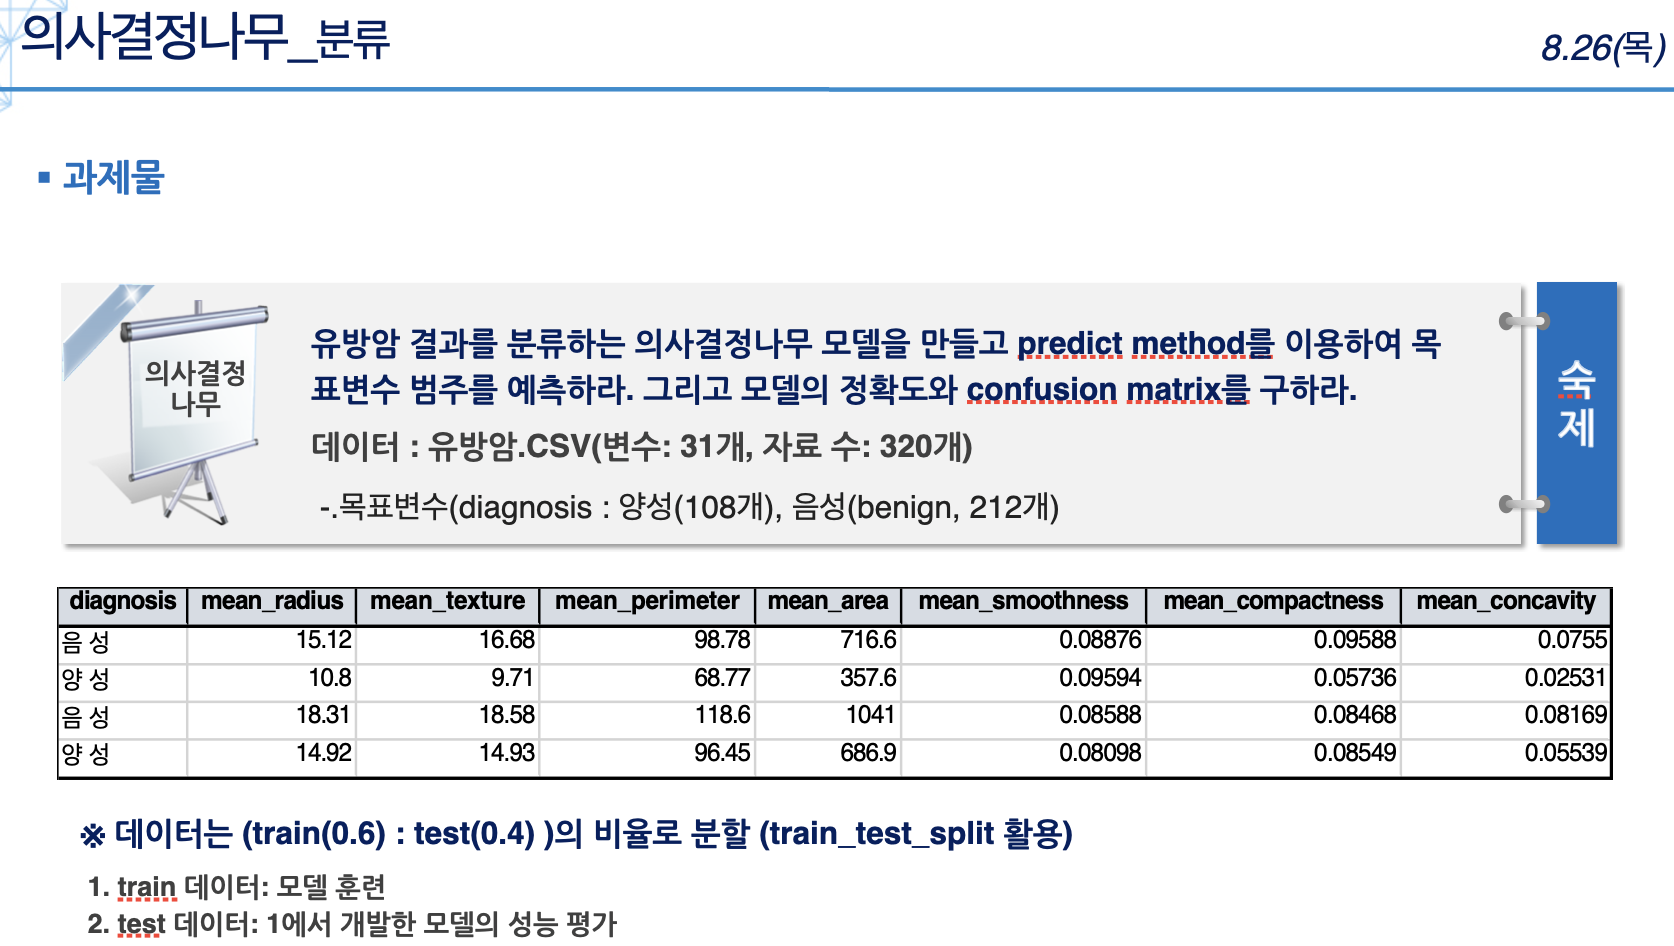

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale, minmax_scale, robust_scale

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

matplotlib.rc('font', family='AppleGothic')
plt.rc('font',  family='AppleGothic')

from sklearn.model_selection import train_test_split


from sklearn.model_selection import GridSearchCV
from datetime import datetime

#from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.api import Logit

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

# 데이터 이해: 
## 배경 지식 조사: 유방암 악성 종양은 불균형하게 오목하고 일그러진 모양을 띈다.
##### 출처: 
http://www.samsunghospital.com/dept/medical/healthSub02View.do?content_id=1750&DP_CODE=RT
## 가설 설정: 유방암 양성 세포는 일그러진 모양을 띈다.

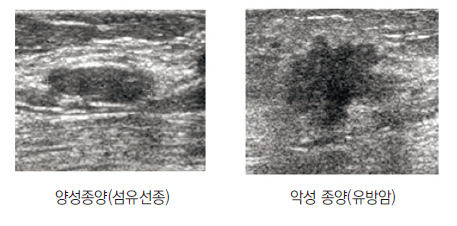

In [8]:
## 데이터 구성하기
df_raw = pd.read_csv('유방암.csv', engine='python', encoding='cp949')
df_raw.head(n=3)

,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,음성,15.12,16.68,98.78,716.6,0.08876,0.09588,0.07550,0.04079,0.1594,...,17.77,20.24,117.70,989.5,0.1491,0.3331,0.3327,0.12520,0.3415,0.09740
1,양성,10.80,9.71,68.77,357.6,0.09594,0.05736,0.02531,0.01698,0.1381,...,11.60,12.02,73.66,414.0,0.1436,0.1257,0.1047,0.04603,0.2090,0.07699
2,음성,18.31,18.58,118.60,1041.0,0.08588,0.08468,0.08169,0.05814,0.1621,...,21.31,26.36,139.20,1410.0,0.1234,0.2445,0.3538,0.15710,0.3206,0.06938


In [9]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                320 non-null    object 
 1   mean_radius              320 non-null    float64
 2   mean_texture             320 non-null    float64
 3   mean_perimeter           320 non-null    float64
 4   mean_area                320 non-null    float64
 5   mean_smoothness          320 non-null    float64
 6   mean_compactness         320 non-null    float64
 7   mean_concavity           320 non-null    float64
 8   mean_concave_points      320 non-null    float64
 9   mean_symmetry            320 non-null    float64
 10  mean_fractal_dimension   320 non-null    float64
 11  radius_error             320 non-null    float64
 12  texture_error            320 non-null    float64
 13  perimeter_error          320 non-null    float64
 14  area_error               3

## 결측치 확인


In [10]:
df_raw.isnull().sum()

diagnosis                  0
mean_radius                0
mean_texture               0
mean_perimeter             0
mean_area                  0
mean_smoothness            0
mean_compactness           0
mean_concavity             0
mean_concave_points        0
mean_symmetry              0
mean_fractal_dimension     0
radius_error               0
texture_error              0
perimeter_error            0
area_error                 0
smoothness_error           0
compactness_error          0
concavity_error            0
concave_points_error       0
symmetry_error             0
fractal_dimension_error    0
worst_radius               0
worst_texture              0
worst_perimeter            0
worst_area                 0
worst_smoothness           0
worst_compactness          0
worst_concavity            0
worst_concave_points       0
worst_symmetry             0
worst_fractal_dimension    0
dtype: int64

## 데이터 변환: 목표 변수인 유방암 진단결과를 0(음성),1(양성)로 변환

In [11]:
df_raw.replace({'diagnosis': '양성'}, 1, inplace=True)
df_raw.replace({'diagnosis': '음성'}, 0, inplace=True)

In [12]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw.drop("diagnosis",axis=1),df_raw["diagnosis"], test_size = 0.3, random_state=1234)
print('train x data size : {}'.format(df_train_x.shape))
print('train y data size : {}'.format(df_train_y.shape))
print('test x data size : {}'.format(df_test_x.shape))
print('test y data size : {}'.format(df_test_y.shape))

train x data size : (224, 30)
train y data size : (224,)
test x data size : (96, 30)
test y data size : (96,)


# 기본 옵션으로 모델 생성
train 데이터로 학습한 모델의 정확도가 100%으로 train 데이터에 과적합 되어있는 것으로 해석된다.

따라서 로지스틱 회귀 모델에 파라메터를 최적화할 필요성이 있다.

In [13]:
tree_uncustomized =DecisionTreeClassifier(random_state=1234)
tree_uncustomized.fit(df_train_x,df_train_y)
print("Accuracy in train set:{:.3f}".format(tree_uncustomized.score(df_train_x,df_train_y)))
print("Accuracy in test set:{:.3f}".format(tree_uncustomized.score(df_test_x,df_test_y)))

Accuracy in train set:1.000
Accuracy in test set:0.896


# 모델 파라메터 조정 1: max_depth 최대 깊이 =>6선택
- 선택 이유


train, test 정확도가 87.5%이상 높아진 지점이며, train, test 값의 차이가 일정해지는 지점인 3 이후 값들 중,

3은 트리 모양이 과소 적합이었기 때문에 과소 적합을 방지하고자 6을 선택했습니다.

In [14]:
train_accuracy = []; test_accuracy =[]
para_depth = [depth for depth in range(1,11)]

for v_min_max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth = v_min_max_depth, random_state=1234)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"]=train_accuracy
df_accuracy_depth["TestAccuracy"]=test_accuracy

In [15]:
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.938,0.823
1,2,0.978,0.865
2,3,1.000,0.896
3,4,1.000,0.896
4,5,1.000,0.896
5,6,1.000,0.896
6,7,1.000,0.896
7,8,1.000,0.896
8,9,1.000,0.896
9,10,1.000,0.896


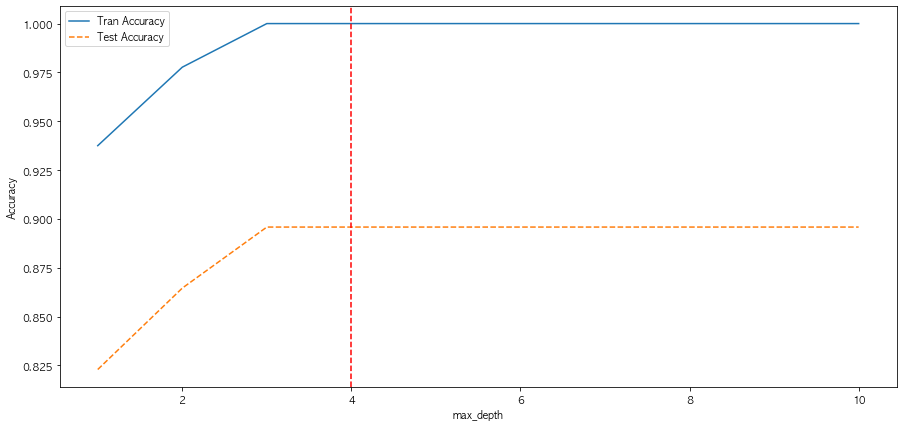

In [16]:
plt.figure(figsize=(15, 7))
plt.plot(para_depth,train_accuracy,linestyle='-',label="Tran Accuracy")
plt.plot(para_depth,test_accuracy,linestyle='--',label="Test Accuracy")
plt.legend()

plt.ylabel('Accuracy')
plt.xlabel('max_depth')

plt.axvline(x=4, linestyle='--', c='r')

plt.legend()


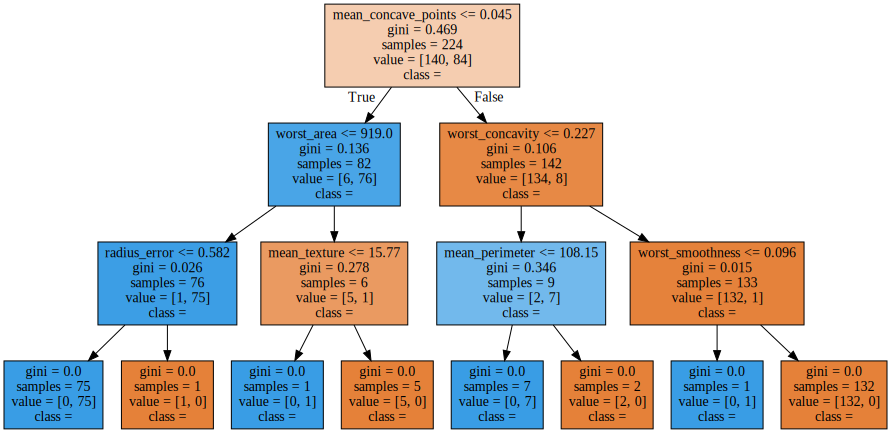

In [17]:
v_feature_name = df_train_x.columns
tree_low=DecisionTreeClassifier(max_depth=6,random_state=1234)
tree_low.fit(df_train_x,df_train_y)

export_graphviz(tree_low,out_file="tree_high.dot",class_names=["음성","양성"],
                feature_names = v_feature_name,impurity =True,filled=True)
with open("tree_high.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# 모델 파라메터 조정 2: 분리 노드의 최소 자료 수 =>default(2)선택
분리 노드의 최소 자료 수에 따른 train, test accuracy 변화가 없으므로 

분리 노드의 최소 자료 수가 모델 정확도에 영향을 미치지 않는다.

따라서 default값을 사용하기로 결정하였다.


In [18]:
train_accuracy = []; test_accuracy =[]
para_split = [n_split*10 for n_split in range(1,11)]

for v_min_sample_split in para_split:
    tree = DecisionTreeClassifier(min_samples_split=v_min_max_depth, max_depth = 6, random_state=1234)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"]=train_accuracy
df_accuracy_split["TestAccuracy"]=test_accuracy

In [19]:
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,0.987,0.865
1,20,0.987,0.865
2,30,0.987,0.865
3,40,0.987,0.865
4,50,0.987,0.865
5,60,0.987,0.865
6,70,0.987,0.865
7,80,0.987,0.865
8,90,0.987,0.865
9,100,0.987,0.865


# 분리 노드의 최소 자료 수에 따른 train, test accuracy 변화

분리 노드의 최소 자료 수가 모델 정확도에 영향을 미치지 않는다.

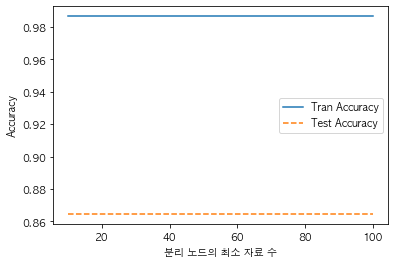

In [20]:
plt.plot(para_split,train_accuracy,linestyle='-',label="Tran Accuracy")
plt.plot(para_split,test_accuracy,linestyle='--',label="Test Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('분리 노드의 최소 자료 수')
plt.legend()

#  분리 노드의 최소 자료 수: default(2)선택 결과

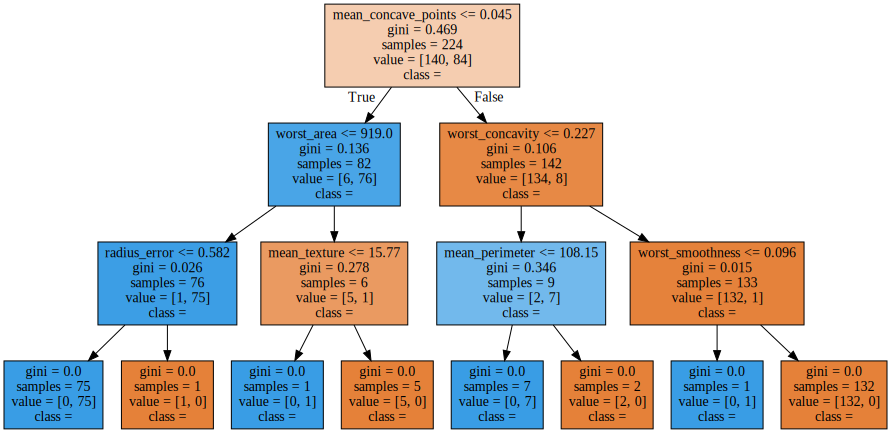

In [21]:
tree_low=DecisionTreeClassifier(max_depth=6, min_samples_split=2,random_state=1234)
tree_low.fit(df_train_x,df_train_y)

export_graphviz(tree_low,out_file="tree_high.dot",class_names=["음성","양성"],
                feature_names = v_feature_name,impurity =True,filled=True)
with open("tree_high.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# 모델 파라메터 조정 3:  잎사귀 노드의 최소 자료 수 =>2선택
잎사귀 노드의 최소 자료 수 증가에 따라 모델 정확도는 감소한다.

따라서 train, test accuracy가 87.5%이상으로 높은 2,4를 비교하였다.

결과: min_samples_leaf=2 경우, min_samples_leaf=4보다 더 균형적이다. 따라서 2를 선택하였다.


In [22]:
train_accuracy = []; test_accuracy =[]
para_leaf = [n_leaf*2 for n_leaf in range(1,11)]

for v_min_sample_leaf in para_leaf:
    tree = DecisionTreeClassifier(min_samples_leaf=v_min_sample_leaf, min_samples_split=2,max_depth = 4, random_state=1234)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"]=train_accuracy
df_accuracy_leaf["TestAccuracy"]=test_accuracy

In [23]:
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,2,0.987,0.906
1,4,0.978,0.885
2,6,0.978,0.865
3,8,0.969,0.875
4,10,0.955,0.875
5,12,0.946,0.802
6,14,0.938,0.823
7,16,0.938,0.823
8,18,0.938,0.823
9,20,0.938,0.823


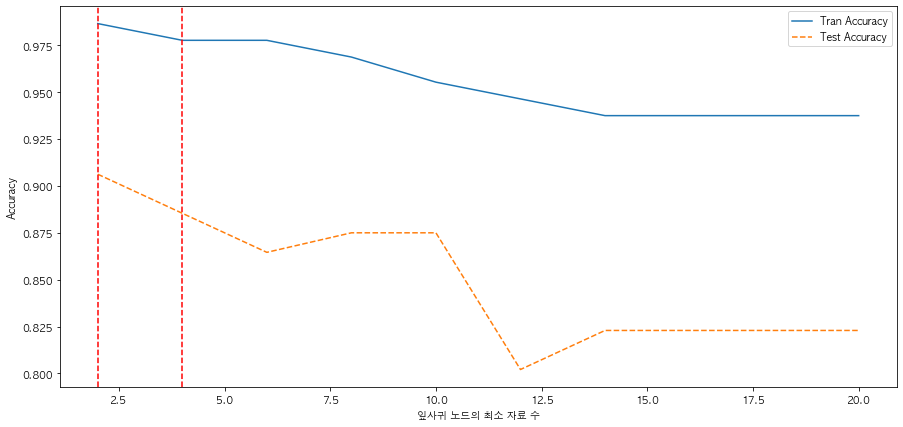

In [24]:
plt.figure(figsize=(15, 7))
plt.plot(para_leaf,train_accuracy,linestyle='-',label="Tran Accuracy")
plt.plot(para_leaf,test_accuracy,linestyle='--',label="Test Accuracy")
plt.axvline(x=2, linestyle='--', c='r')
plt.axvline(x=4, linestyle='--', c='r')
plt.ylabel('Accuracy')
plt.xlabel('잎사귀 노드의 최소 자료 수')
plt.legend()

# min_samples_leaf=2 경우: min_samples_leaf=4보다 더 균형적임

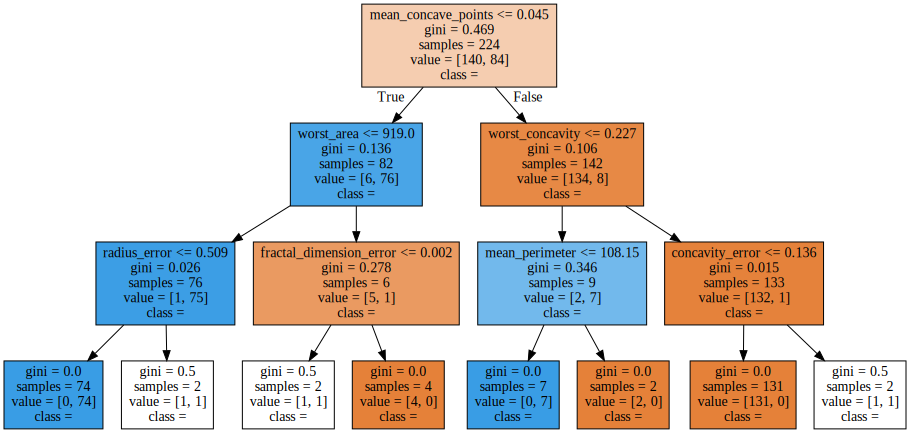

In [25]:
tree_low=DecisionTreeClassifier(max_depth=4,min_samples_leaf=2,min_samples_split=2, random_state=1234)
tree_low.fit(df_train_x,df_train_y)

export_graphviz(tree_low,out_file="tree_low.dot",class_names=["음성","양성"],
                feature_names = v_feature_name,impurity =True,filled=True)
with open("tree_low.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# min_samples_leaf=4 경우: 상대적으로 균형적이지 않음

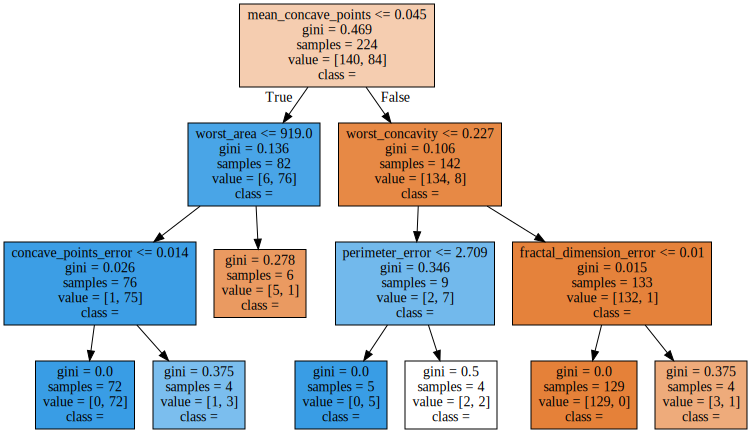

In [26]:
tree_low=DecisionTreeClassifier(max_depth=4,min_samples_leaf=4,min_samples_split=2, random_state=1234)
tree_low.fit(df_train_x,df_train_y)

export_graphviz(tree_low,out_file="tree_low.dot",class_names=["음성","양성"],
                feature_names = v_feature_name,impurity =True,filled=True)
with open("tree_low.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# 최종 모델:
## 하이퍼 파라메터: 
max_depth=4,min_samples_split=2,min_samples_leaf=2

## 해석



### 어떤 설명 변수가 유방암 진단에 가장 큰 영향을 미치는가?
세포의 평균 오목한 점의 수(mean concave points)이다.

### 어떤 세포가 유방암 양성인가?

#### 1번째 경우: 

세포의 평균 오목한 점의 수(mean concave points)가 0.045개 이하이고, 

최대 면적(worst area)이 919이하이고, 

반경의 표준오차가 0.509보다 작으면 양성으로 분류된다.

#### 2번째 경우:

세포의 평균 오목한 점의 수(mean concave points)가 0.045개 초과이고, 

최대 오목함(worst concavity)이 0.227이하이고,

평균 둘레(mean perimeter)가 108.15이하이면 양성으로 분류된다.



In [27]:
tree_final =DecisionTreeClassifier(max_depth=4,min_samples_leaf=2,min_samples_split=2, random_state=1234)
tree_final.fit(df_train_x,df_train_y) 

DecisionTreeClassifier(max_depth=4, min_samples_leaf=2, random_state=1234)

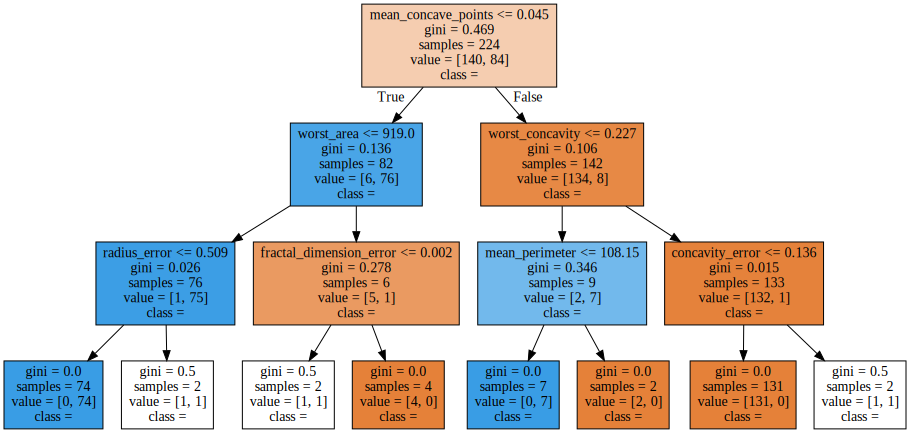

In [28]:
export_graphviz(tree_final,out_file="tree_final.dot",class_names=["음성","양성"],
                feature_names = v_feature_name,impurity =True,filled=True)
with open("tree_final.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# 최종 모델 평가

## 📌해석
모델 정확도(정분류율)는 90.6%이다.

의학 분야이다보니 더 높은 정확도가 필요할 수 있다.

목표 변수 1기준 f1-score은 0.809이다.


In [29]:
y_pred=tree_final.predict(df_test_x)
print("Accuracy:{0:.3f}".format(tree_final.score(df_test_x,df_test_y)))
print("Confusion matrix:\n{}".format(confusion_matrix(df_test_y,y_pred)))

print(classification_report(df_test_y,y_pred,digits=3))

Accuracy:0.906
Confusion matrix:
[[68  4]
 [ 5 19]]
              precision    recall  f1-score   support

           0      0.932     0.944     0.938        72
           1      0.826     0.792     0.809        24

    accuracy                          0.906        96
   macro avg      0.879     0.868     0.873        96
weighted avg      0.905     0.906     0.906        96



# 설명 변수의 중요도
## 📌해석
1. 유방암 양성 진단에 세포의 평균 오목한 점의 수(mean concave points)의 상대적 중요도가 77.2%로 매우 높다.

    이는 데이터 조사에서 설정한 가설인 "유방암 양성 세포는 일그러진 모양을 띈다."에서 예상한 결과와 같다.

2. 유방암 양성 진단에 세포의 최대 오목함, 세포 최대 면적 변수도 중요한 것으로 생각된다.

2. error변수들은 상대적 중요도가 거의 0에 수렴한다.
    이는 변수들의 측정 오차이므로 중요도가 작아야하는 당연히 예상 가능한 결과이다.

In [30]:
df_importance=pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"]=tree_final.feature_importances_

df_importance.sort_values("Importance",ascending=False,inplace=True)
df_importance.round(3)

,Feature,Importance
7,mean_concave_points,0.772
26,worst_concavity,0.098
23,worst_area,0.073
2,mean_perimeter,0.031
16,concavity_error,0.010
10,radius_error,0.010
19,fractal_dimension_error,0.007
22,worst_perimeter,0.000
18,symmetry_error,0.000
20,worst_radius,0.000


Text(0, 0.5, '설명변수')

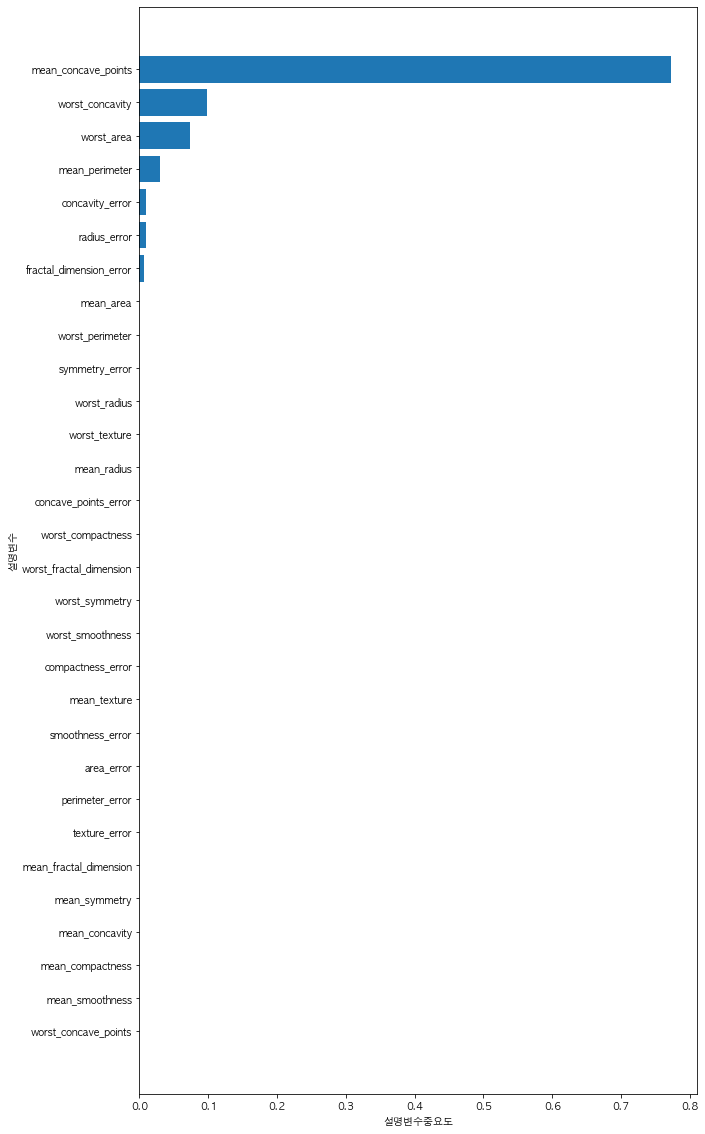

In [31]:
df_importance.sort_values("Importance",ascending=True,inplace=True)
coordinates=range(len(df_importance))
plt.figure(figsize=(10,20))
plt.barh(y=coordinates,width=df_importance["Importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("설명변수중요도")
plt.ylabel("설명변수")

In [32]:
#estimator = DecisionTreeClassifier()
#param_grid={"max_depth":para_depth,"min_samples_split":para_split,"min_samples_leaf":para_leaf}
#grid_dt= GridSearchCV(estimator,param_grid,scoring="accuracy",n_jobs=-1)
#grid_dt.fit(df_train_x,df_train_y)

#print("best estimator model:\n{}".format(grid_dt.best_estimator_))
#print("\nbest parameter:\n{}".format(grid_dt.best_params_))
#print("\nbest score:\n{}".format(grid_dt.best_score_.round(3)))